In [ ]:
! pip install japanize-matplotlib
! pip install umap-learn

In [2]:
import torch
import numpy as np
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from umap import UMAP

import os
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, img_size=(128, 128)):
        self.root_dir = root_dir
        
        target_extensions = ("jpg", "jpeg", "png")
        self.image_files = [str(path.name) for path in Path(root_dir).glob("*") if path.suffix[1:] in target_extensions]
        
        self.transform = transform or transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image
    
    def get_all_tensor(self):
        return torch.stack([self[i] for i in range(len(self))])


class TensorPlotter:
    def __init__(self, tensors:list, device="cpu", labels=None):
        self.tensors = tensors
        self.num_tensors = len(tensors)
        self.labels = labels or [f"Tensor {i+1}({len(self.tensors[i])})" for i in range(self.num_tensors)]
        assert self.num_tensors == len(self.labels), "Number of tensors and labels should match."
        
        # self.color_map =  plt.cm.Set1([i for i in range(self.num_tensors)])
        # self.color_map =  plt.cm.Dark2([i for i in range(self.num_tensors)])
        self.color_map =  plt.cm.tab10([i for i in range(self.num_tensors)])
        # self.color_map =  plt.cm.hsv(np.linspace(0, 1, self.num_tensors))
        
        self.device = device
        
        return None
    
    def _prepare_data(self, dim):
        reshaped_data = [tensor.reshape(-1, 4) for tensor in self.tensors]
        combined_data = np.vstack(reshaped_data)
        pca = PCA(n_components=dim)
        self.reduced_data = pca.fit_transform(combined_data)

    def pca_plot(self, dim=2, plot_title_append=""):
        
        if dim not in [2, 3]:
            raise ValueError("Only 2D and 3D visualizations are supported.")
        
        reshaped_data = [tensor.reshape(tensor.size(0), -1) for tensor in self.tensors]
        combined_data = np.vstack(reshaped_data)
        
        pca = PCA(n_components=dim)
        self.reduced_data = pca.fit_transform(combined_data)
        
        plot_title = f"{dim}D PCA of 4D Tensor Data"+plot_title_append
        
        if dim == 2:
            self._plot_2d(plot_title)
        else:
            self._plot_3d(plot_title)

    def tsne_plot(self, dim=2, plot_title_append=""):
        
        '''
            GPUがある場合、以下の警告が出る？
            OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
        '''
        
        if dim not in [2, 3]:
            raise ValueError("Only 2D and 3D visualizations are supported.")
        
        reshaped_data = [tensor.reshape(tensor.size(0), -1) for tensor in self.tensors]
        combined_data = np.vstack(reshaped_data)
        
        tsne = TSNE(n_components=dim)
        self.reduced_data = tsne.fit_transform(combined_data)
        
        plot_title = f"{dim}D t-SNE of 4D Tensor Data"+plot_title_append
        
        if dim == 2:
            self._plot_2d(plot_title)
        else:
            self._plot_3d(plot_title)

    def umap_plot(self, dim=2, random_state=0, plot_title_append=""):
        
        if dim not in [2, 3]:
            raise ValueError("Only 2D and 3D visualizations are supported.")
        
        reshaped_data = [tensor.reshape(tensor.size(0), -1) for tensor in self.tensors]
        combined_data = np.vstack(reshaped_data)
        
        umap = UMAP(n_components=dim, random_state=random_state)
        self.reduced_data = umap.fit_transform(combined_data)
        
        plot_title = f"{dim}D UMAP of 4D Tensor Data"+plot_title_append
        
        if dim == 2:
            self._plot_2d(plot_title)
        else:
            self._plot_3d(title=plot_title)

    def _plot_2d(self, title="", point_size=10):
        colors = self.color_map
        
        split_idx = [sum([len(t) for t in self.tensors[:i+1]]) for i in range(len(self.tensors))][:-1]
        for idx, data in enumerate(np.split(self.reduced_data, split_idx)):
            sns.kdeplot(x=data[:, 0], y=data[:, 1], fill=True, color=colors[idx]*0.7, alpha=0.3)
            plt.scatter(data[:, 0], data[:, 1], color=colors[idx], label=self.labels[idx], s=point_size)

        plt.title(title)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.show()
        plt.cla(); plt.clf()
        
        return None

    def _plot_3d(self, title="", point_size=10):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        colors = self.color_map
        
        split_idx = [sum([len(t) for t in self.tensors[:i+1]]) for i in range(len(self.tensors))][:-1]
        for idx, data in enumerate(np.split(self.reduced_data, split_idx)):
            ax.scatter(data[:,0], data[:,1], data[:,2], color=colors[idx], label=self.labels[idx], s=point_size)

        ax.set_title(title)
        plt.legend(loc='upper left', bbox_to_anchor=(1.3, 1))
        plt.show()
        plt.cla(); plt.clf()

        return None

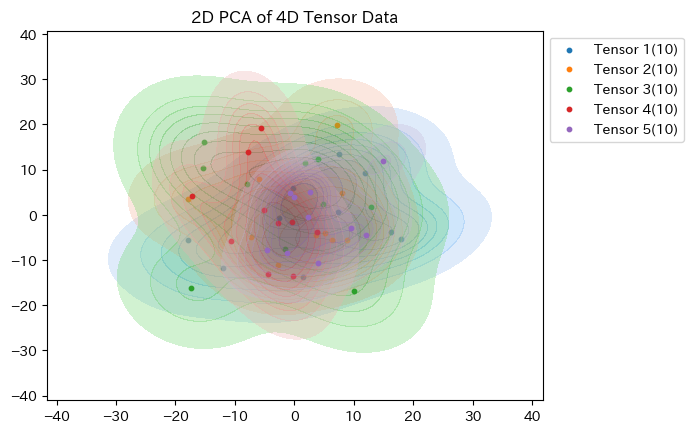

<Figure size 640x480 with 0 Axes>

In [3]:
# 使用例

sample_num = 5
data = [torch.rand(10, 3, 128, 128) for _ in range(sample_num)]
custom_labels = [f"CustomLabel {i+1}" for i in range(sample_num)]

plotter = TensorPlotter(data, custom_labels)
plotter.pca_plot(dim=2)  # 2次元でのプロット
# plotter.tsne_plot(dim=2)  # 2次元でのプロット
# plotter.umap_plot(dim=2)  # 2次元でのプロット

# plotter.pca_plot(dim=3)  # 3次元でのプロット
# plotter.tsne_plot(dim=3)  # 3次元でのプロット
# plotter.umap_plot(dim=3)  # 3次元でのプロット

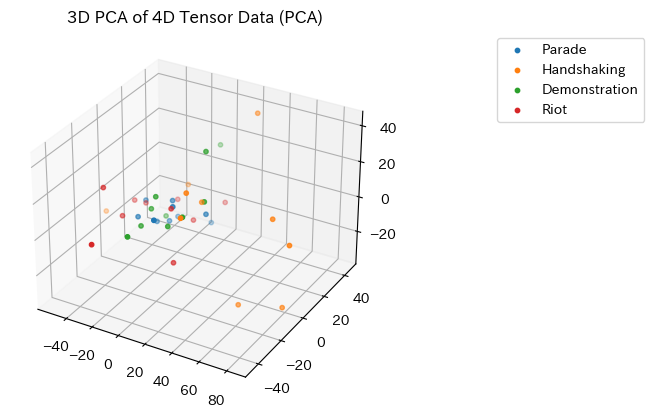

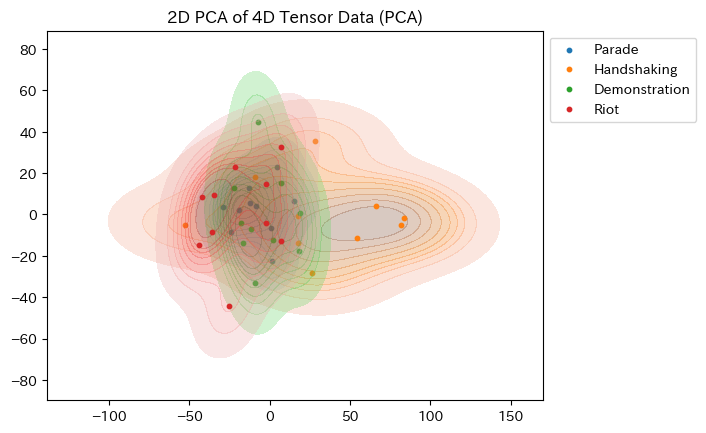

<Figure size 640x480 with 0 Axes>

In [4]:
data_list = [
    {
        "name": "Parade",
        "path": Path("../../sample_data/WIDER_OpenData/0--Parade/"),
    },
    {
        "name": "Handshaking",
        "path": Path("../../sample_data/WIDER_OpenData/1--Handshaking/"),
    },
    {
        "name": "Demonstration",
        "path": Path("../../sample_data/WIDER_OpenData/2--Demonstration/"),
    },
    {
        "name": "Riot",
        "path": Path("../../sample_data/WIDER_OpenData/3--Riot/"),
    },
]


features_list = [ImageDataset(str(data["path"]), img_size=(128, 128)).get_all_tensor() for data in data_list]
plotter = TensorPlotter(features_list, labels=[data["name"] for data in data_list])
plotter.pca_plot(dim=3, plot_title_append=" (PCA)")
plotter.pca_plot(dim=2, plot_title_append=" (PCA)")